In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import dotenv
import os
import matplotlib.pyplot as plt
import requests
from requests.auth import HTTPBasicAuth
import seaborn as sns
from scipy import stats
from tqdm.notebook import tqdm
from statistics import median, stdev, variance, mean

plt.rcParams["font.family"] = "Arial"
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 12
plt.rcParams["ytick.major.size"] = 12
plt.rcParams["xtick.major.pad"] = 18
plt.rcParams["ytick.major.pad"] = 18
plt.rcParams['axes.linewidth'] = 1.0

dotenv.load_dotenv()

headers = {"Authorization": f"Bearer {os.environ.get('GITHUB_TOKEN')}"}


def run_query(query):
    request = requests.post('https://api.github.com/graphql', json={'query': query}, headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))

## 必要データの取得 （最初の１回のみ実行）

GraphQL のクエリテスト

In [2]:
query = """
{
    user(login:"Hayashi-Yudai") {
        pullRequests(last: 1, orderBy:{direction: DESC, field:CREATED_AT}) {
            totalCount
            nodes {
                id
                merged
                mergedAt
                author {
                    login
                }
                mergedBy {
                    login
                }
                number
                repository {
                    name
                    owner {
                        login
                    }
                }
            }
        }
    }
}
"""
result = run_query(query) # Execute the query
result

{'data': {'user': {'pullRequests': {'totalCount': 86,
    'nodes': [{'id': 'MDExOlB1bGxSZXF1ZXN0MjcyNzUzNTMw',
      'merged': True,
      'mergedAt': '2019-04-23T14:22:02Z',
      'author': {'login': 'Hayashi-Yudai'},
      'mergedBy': {'login': 'Hayashi-Yudai'},
      'number': 2,
      'repository': {'name': 'ML_models',
       'owner': {'login': 'Hayashi-Yudai'}}}]}}}}

In [3]:
user_info = pd.read_csv("./data/user_info_1.csv")
user_info.head()

,username,star,created_at,updated_at,elapsed_time,star_per_day,star_per_day_biased,issue_count,issue_per_day_biased
0,collymore,8,2009-02-19 16:16:06,2020-09-26 11:37:56,4236,0.001889,0.001889,7,0.001653
1,sujanucsc,9,2009-03-12 16:20:20,2020-08-16 18:30:00,4175,0.002156,0.002156,0,0.000000
2,Theorem,0,2018-03-15 21:04:11,2020-07-28 05:07:27,865,0.000000,0.000000,0,0.000000
3,mussawir20,1,2009-05-03 00:01:17,2020-09-18 14:41:17,4156,0.000241,0.000241,0,0.000000
4,bytheway,958,2008-04-04 17:43:29,2020-09-24 13:30:55,4555,0.210318,0.210318,11,0.002415


上のユーザーリストから `username` を取ってきて、そのユーザーの出している Pull Request を最大 100 件新しい順に取得する

In [5]:
pr_ids = []
usernames = []
are_merged = []
merged_at = []
pr_authors = []
merged_by = []

for user in tqdm(user_info.username):
    query = '{\n  user(login: "' + user + '") {' + \
        """
        pullRequests(last: 100, orderBy:{direction: DESC, field:CREATED_AT}) {
            nodes {
                id
                merged
                mergedAt
                author {
                    login
                }
                mergedBy {
                    login
                }
                number
                repository {
                    name
                    owner {
                        login
                    }
                }
            }
        }
    }
}
        """
    try:
        prs = run_query(query)["data"]["user"]["pullRequests"]["nodes"]
    except:
        continue
    
    for pr in prs:
        pr_ids.append(pr["id"])
        usernames.append(user)
        are_merged.append(pr["merged"])
        merged_at.append(pr["mergedAt"])
        pr_authors.append(pr["author"]["login"])
        
        if pr["merged"]:
            try:
                merged_by.append(pr["mergedBy"]["login"])
            except :
                merged_by.append(None)
        else:
            merged_by.append(None)
    

In [6]:
pr_merge = pd.DataFrame({
    "id": pr_ids,
    "username": usernames,
    "is_merged": are_merged,
    "merged_at": merged_at,
    "author": pr_authors,
    "merged_by": merged_by,
})

pr_merge.to_csv("./data/PR_merge_info.csv", index=False)
pr_merge.head()

,id,username,is_merged,merged_at,author,merged_by
0,MDExOlB1bGxSZXF1ZXN0Mjc0MDk5NTYz,collymore,False,None,collymore,None
1,MDExOlB1bGxSZXF1ZXN0MjY3MTA2NjQ2,collymore,True,2019-04-03T15:45:05Z,collymore,collymore
2,MDExOlB1bGxSZXF1ZXN0MjQyNDMwOTI1,collymore,True,2019-01-07T09:39:55Z,collymore,lewisvoncken
3,MDExOlB1bGxSZXF1ZXN0MjQyNDI4OTYy,collymore,False,None,collymore,None
4,MDExOlB1bGxSZXF1ZXN0MjM3ODM3MzMy,collymore,True,2018-12-13T19:46:14Z,collymore,filrak


## データの解析

In [7]:
pr_merge = pd.read_csv("./data/PR_merge_info.csv")

In [8]:
def time_format(t):
    try:
        time = datetime.strptime(t, "%Y-%m-%dT%H:%M:%SZ")
    except:
        return None
    
    return time

pr_merge["merged_at"] = pr_merge.merged_at.apply(time_format)

In [9]:
pr_merge["merge_oneself"] = pr_merge.author == pr_merge.merged_by

In [16]:
pr_merge.head()

,id,username,is_merged,merged_at,author,merged_by,merge_oneself
0,MDExOlB1bGxSZXF1ZXN0Mjc0MDk5NTYz,collymore,False,NaT,collymore,NaN,False
1,MDExOlB1bGxSZXF1ZXN0MjY3MTA2NjQ2,collymore,True,2019-04-03 15:45:05,collymore,collymore,True
2,MDExOlB1bGxSZXF1ZXN0MjQyNDMwOTI1,collymore,True,2019-01-07 09:39:55,collymore,lewisvoncken,False
3,MDExOlB1bGxSZXF1ZXN0MjQyNDI4OTYy,collymore,False,NaT,collymore,NaN,False
4,MDExOlB1bGxSZXF1ZXN0MjM3ODM3MzMy,collymore,True,2018-12-13 19:46:14,collymore,filrak,False


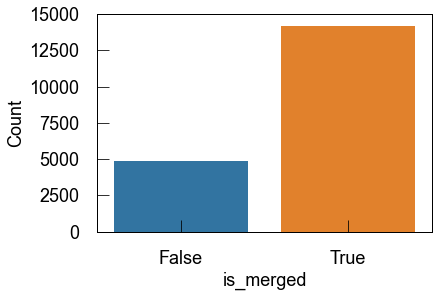

In [12]:
sns.countplot(x="is_merged",  data=pr_merge)
plt.ylim(0, 15000)
plt.xlabel("is_merged", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.show()

マージされたPRとマージされなかったPRの割合。全体の 1/4 くらいがマージされていないことがわかる。

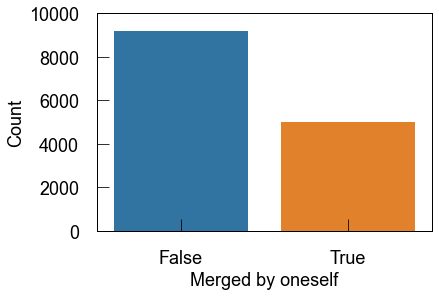

In [20]:
sns.countplot(x="merge_oneself",  data=pr_merge[pr_merge.is_merged])
plt.ylim(0, 10000)
plt.xlabel("Merged by oneself", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.show()

自分でPR作ってマージしているユーザーも一定数いる。ここからユーザーごとのPRを分析していく

In [21]:
pr_by_user = pr_merge[["username", "is_merged"]].groupby("username").agg(np.sum)

In [22]:
def false_sum(x):
    result = 0
    for e in x:
        if not e:
            result += 1
    
    return result

pr_by_user["not_merged"] = pr_merge[["username", "is_merged"]].groupby("username").agg(false_sum)

In [110]:
def length(x):
    return len(x)

def merged_oneself_ratio(x):
    return len(x[x.merge_oneself]) / (len(x[x.is_merged]) + 1)

In [111]:
pr_by_user["total_pr_num"] = pr_merge[["username", "is_merged"]].groupby("username").agg(length).is_merged
pr_by_user["merged_ratio"] = pr_by_user.is_merged / (pr_by_user.is_merged + pr_by_user.not_merged)
pr_by_user["merged_oneself_ratio"] = pr_merge[[
    "username", "merge_oneself", "is_merged"
]].groupby("username").agg(merged_oneself_ratio).merge_oneself
pr_by_user["not_merged_ratio"] = 1 - pr_by_user.merged_ratio
pr_by_user["merged_latest"] = pr_merge[["username", "merged_at"]].groupby("username").agg(np.max).merged_at
pr_by_user["merged_oldest"] = pr_merge[["username", "merged_at"]].groupby("username").agg(np.min).merged_at

In [112]:
def pr_by_day(x):
    if (x.merged_latest-x.merged_oldest).days == 0:
        return 0
    else:
        return x.total_pr_num / (x.merged_latest-x.merged_oldest).days

pr_by_user["pr_per_day"] = pr_by_user.apply(pr_by_day, axis=1)

In [113]:
pr_by_user.head()

,is_merged,not_merged,total_pr_num,merged_ratio,merged_oneself_ratio,not_merged_ratio,merged_latest,merged_oldest,pr_per_day
username,,,,,,,,,
Abizern,74,26,100,0.740000,0.013333,0.260000,2015-11-12 18:08:10,2010-12-06 17:50:50,0.055494
Anks,8,8,16,0.500000,0.222222,0.500000,2020-07-21 07:31:42,2011-12-27 14:56:46,0.005115
Auswaschbar,0,2,2,0.000000,0.000000,1.000000,NaT,NaT,NaN
BrianMowrey,4,3,7,0.571429,0.000000,0.428571,2015-05-26 10:08:37,2015-02-27 06:17:08,0.079545
CHH,42,11,53,0.792453,0.232558,0.207547,2020-02-20 22:33:51,2011-12-28 16:46:32,0.017809


In [114]:
len(pr_by_user)

519

PRを１つ以上出しているユーザーは 519人/1000人 しかいない

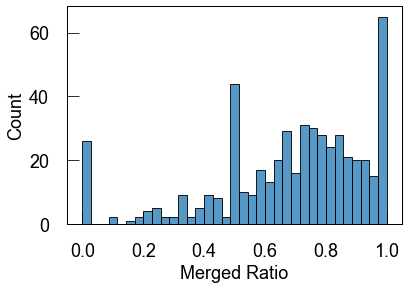

In [115]:
sns.histplot(pr_by_user.merged_ratio, bins=35)
plt.xlabel("Merged Ratio", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.show()

出したPRの内、マージされたものの割合。出したPRが全てマージされているのは自分でPR出して自分でマージしているパターンか？

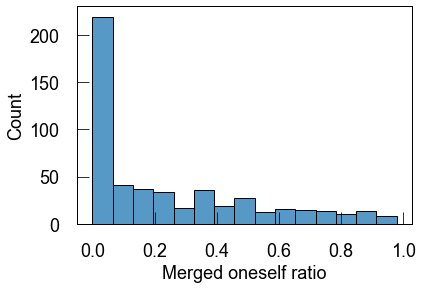

In [116]:
sns.histplot(pr_by_user.merged_oneself_ratio, bins=15)
plt.xlabel("Merged oneself ratio", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.show()

自分でマージしている人はそんなに多くない印象

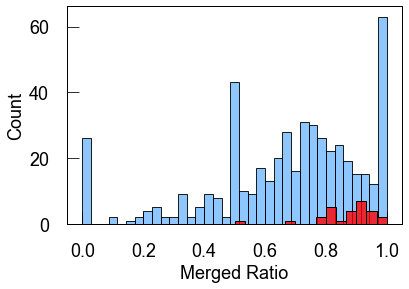

In [125]:
th = 0.8

sns.histplot(
    pr_by_user[pr_by_user.merged_oneself_ratio < th].merged_ratio,
    bins=35, color="dodgerblue", alpha=0.5
)
sns.histplot(
    pr_by_user[pr_by_user.merged_oneself_ratio >= th].merged_ratio,
    bins=15, color="r", alpha=0.8
)
plt.xlabel("Merged Ratio", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.show()

赤色のグラフが自分でマージしているPRの割合が80%以上のユーザーのマージ率。水色が自分でマージしているPRの割合が50%未満のユーザーのマージ率。50%未満のヒストグラムでもマージ率が１のユーザー数が多いのは変わらないが、80%以上のユーザーのほうがマージ率１のユーザーの多さは顕著

マージ率0, 0.5, 1が多いのはPR回数が少ないユーザーが多いからである気がしてきた

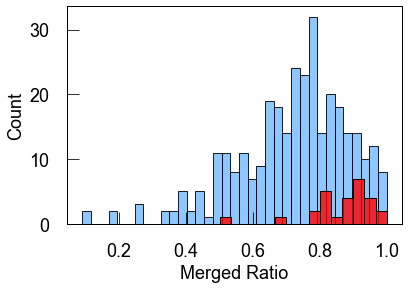

In [126]:
th = 0.8


sns.histplot(
    pr_by_user[(pr_by_user.merged_oneself_ratio < th) & (pr_by_user.total_pr_num > 8)].merged_ratio,
    bins=35, color="dodgerblue", alpha=0.5
)
sns.histplot(
    pr_by_user[(pr_by_user.merged_oneself_ratio >= th) & (pr_by_user.total_pr_num > 8)].merged_ratio,
    bins=15, color="r", alpha=0.8
)

plt.xlabel("Merged Ratio", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.show()

うまく分離できた

- 自己完結率（PRからマージまで自分で行う割合）が高いユーザーと低いユーザーではマージ率の分布が異なる
- 自己完結率に閾値を設けてスコアの計算式のパラメータを変える

In [127]:
th = 0.8

high_selfcontain_users = pr_by_user[(pr_by_user.merged_oneself_ratio >= th) & (pr_by_user.total_pr_num > 8)]
low_selfcontain_users = pr_by_user[(pr_by_user.merged_oneself_ratio < th) & (pr_by_user.total_pr_num > 8)]

In [128]:
print("自己完結力　高：")
print(f"mean: {mean(high_selfcontain_users.merged_ratio):.3}")
print(f"stdev: {stdev(high_selfcontain_users.merged_ratio):.3}")
print("")
print("自己完結力　低：")
print(f"mean: {mean(low_selfcontain_users.merged_ratio):.3}")
print(f"stdev: {stdev(low_selfcontain_users.merged_ratio):.3}")

自己完結力　高：
mean: 0.869
stdev: 0.104

自己完結力　低：
mean: 0.719
stdev: 0.168


Pull Request を出している頻度の分布を確認

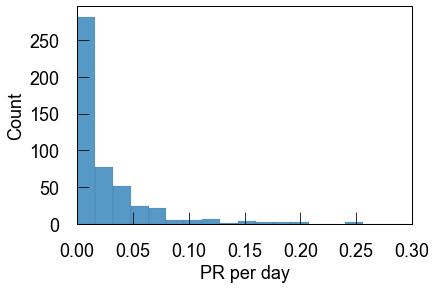

In [18]:
sns.histplot(pr_by_user.pr_per_day, bins=500)
plt.xlim(0, 0.3)
plt.xlabel("PR per day", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.show()

一日あたりの PR 数の分布はやはり 0 に向けて急激に増加する分布となってしまう